In [41]:
try:
    import qdax
except Exception as e:
    print(e)
    %pip install qdax

%pip install "brax<0.9"


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: /Users/lg4615/projects/QDGlue/venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [42]:
import functools
from tqdm import tqdm

import numpy as np
import gymnasium

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from qdax.core.containers.mapelites_repertoire import compute_euclidean_centroids
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.core.map_elites import MAPElites
from qdax.utils.metrics import default_qd_metrics
from qdax.utils.plotting import plot_2d_map_elites_repertoire

from qdglue.tasks.kheperax.task import KheperaxTask

In [43]:
# Defining the algorithms hyperparameters

seed = 42
batch_size = 256
num_evaluations = int(1e6)
num_iterations = num_evaluations // batch_size
grid_shape = (50, 50)
episode_length = 250
mlp_policy_hidden_layer_sizes = (8,)

iso_sigma = 0.2
line_sigma = 0.0

# Init a random key
random_key = jax.random.PRNGKey(seed)
random_key, subkey = jax.random.split(random_key)

In [44]:
# Defining Task Instance

random_key = jax.random.PRNGKey(seed=42)
random_key, subkey = jax.random.split(random_key)
task_instance = KheperaxTask(random_key=subkey)

# Defining scoring function compatible with QDax
def scoring_fn_qdax(parameters, random_key):
    random_key, subkey = jax.random.split(random_key)
    fitnesses, descriptors, info = task_instance.evaluate(parameters, subkey)
    return fitnesses, descriptors, info, random_key

/Users/lg4615/projects/QDGlue/qdglue/tasks/kheperax/tree_utils.py:7: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  batch_size = jax.tree_leaves(tree)[0].shape[0]


In [45]:
# Defining isoline variation emitter (can be used for MAP-Elites)

variation_fn = functools.partial(
    isoline_variation,
    iso_sigma=iso_sigma,
    line_sigma=line_sigma,
)
map_elites_emitter = MixingEmitter(
    mutation_fn=lambda x, y: (x, y),
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size,
)

# PGA-ME Emitter
proportion_mutation_ga = 0.5
## TD3 params
env_batch_size = 100 #@param {type:"number"}
replay_buffer_size = 1000000 #@param {type:"number"}
critic_hidden_layer_size = (256, 256) #@param {type:"raw"}
critic_learning_rate = 3e-4 #@param {type:"number"}
greedy_learning_rate = 3e-4 #@param {type:"number"}
policy_learning_rate = 1e-3 #@param {type:"number"}
noise_clip = 0.5 #@param {type:"number"}
policy_noise = 0.2 #@param {type:"number"}
discount = 0.99 #@param {type:"number"}
reward_scaling = 1.0 #@param {type:"number"}
transitions_batch_size = 256 #@param {type:"number"}
soft_tau_update = 0.005 #@param {type:"number"}
num_critic_training_steps = 300 #@param {type:"number"}
num_pg_training_steps = 100 #@param {type:"number"}
policy_delay = 2 #@param {type:"number"}



# Define the PG-emitter config
from qdax.core.emitters.pga_me_emitter import PGAMEConfig, PGAMEEmitter

pga_emitter_config = PGAMEConfig(
    env_batch_size=env_batch_size,
    batch_size=transitions_batch_size,
    proportion_mutation_ga=proportion_mutation_ga,
    critic_hidden_layer_size=critic_hidden_layer_size,
    critic_learning_rate=critic_learning_rate,
    greedy_learning_rate=greedy_learning_rate,
    policy_learning_rate=policy_learning_rate,
    noise_clip=noise_clip,
    policy_noise=policy_noise,
    discount=discount,
    reward_scaling=reward_scaling,
    replay_buffer_size=replay_buffer_size,
    soft_tau_update=soft_tau_update,
    num_critic_training_steps=num_critic_training_steps,
    num_pg_training_steps=num_pg_training_steps,
    policy_delay=policy_delay,
)

pg_emitter = PGAMEEmitter(
    config=pga_emitter_config,
    policy_network=task_instance._policy_network,
    env=task_instance._env,
    variation_fn=variation_fn,
)



In [46]:
# Define a metrics function
metrics_fn = functools.partial(
    default_qd_metrics,
    qd_offset=0.5,
)

In [47]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn_qdax,
#     emitter=pg_emitter,  # The PG emitter does not work at the moment
    emitter=map_elites_emitter,
    metrics_function=metrics_fn,
)

In [48]:
# TODO: change the get_initial_parameters of Kheperax

init_variables = jnp.asarray(task_instance.get_initial_parameters(seed=seed, number_parameters=batch_size))

In [49]:
# Compute the centroids
x_lim, y_lim = task_instance.descriptor_space_bounds
min_bd, max_bd = zip(x_lim, y_lim)
centroids = compute_euclidean_centroids(
    grid_shape=grid_shape,
    minval=min_bd,
    maxval=max_bd,
)

# Initializes repertoire and emitter state
repertoire, emitter_state, random_key = map_elites.init(
    init_variables, centroids, random_key
)

/Users/lg4615/projects/QDGlue/venv/lib/python3.9/site-packages/qdax/core/map_elites.py:80: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


In [50]:
# define a function that extracts non-empty descriptors and fitnesses
#  from a QDax repertoire

def select_index_pytree(pytree_optimised_gens,
                        index_optimised_gen
                        ):
    return jax.tree_map(
        lambda x: x[index_optimised_gen],
        pytree_optimised_gens
    )

def get_indices_non_empty_cells(repertoire):
    condition = ~jnp.isinf(repertoire.fitnesses)
    indices = jnp.asarray(condition).nonzero()[0]
    return indices.ravel()



def extract_non_empty_cells(repertoire):
    indices = get_indices_non_empty_cells(repertoire)
    
    filtered_genotypes = select_index_pytree(repertoire.genotypes, indices)
    filtered_fitnesses = select_index_pytree(repertoire.fitnesses, indices)
    filtered_descriptors = select_index_pytree(repertoire.descriptors, indices)
    filtered_centroids = select_index_pytree(repertoire.centroids, indices)

    return filtered_fitnesses, filtered_descriptors


In [51]:
from qdglue.metrics.grid_based_metrics import GridMetricsCalculator

x_lim, y_lim = task_instance.descriptor_space_bounds
min_bd, max_bd = zip(x_lim, y_lim)

metrics_calculator = GridMetricsCalculator(
    feature_space=gymnasium.spaces.Box(low=np.asarray(min_bd)-0.01, 
                                       high=np.asarray(max_bd)),
    fitness_bounds=gymnasium.spaces.Box(low=-0.5, high=0.),
    resolution=grid_shape,
    num_points_ccdf=100,
)

print(task_instance.descriptor_space_bounds)

# Run MAP-Elites loop


list_metrics = []
list_evaluations = []

for iteration in tqdm(range(num_iterations)):
    (repertoire, emitter_state, metrics, random_key,) = map_elites.update(
        repertoire,
        emitter_state,
        random_key,
    )
    filtered_fitnesses, filtered_descriptors = extract_non_empty_cells(repertoire)
    
    if iteration % 10 == 0:    
        metrics = metrics_calculator.get_metrics(filtered_fitnesses, filtered_descriptors)
        list_metrics.append(metrics)
        list_evaluations.append(iteration * batch_size)

[(0.0, 1.0), (0.0, 1.0)]


  3%|█████                                                                                                                                                                   | 117/3906 [00:18<10:10,  6.20it/s]


KeyboardInterrupt: 

In [35]:
qd_scores_bound_norm = [m.qd_score_bound_norm for m in list_metrics]
qd_scores_original = [m.qd_score_original for m in list_metrics]
coverages = [m.coverage for m in list_metrics]
max_fitnesses = [m.max_fitness for m in list_metrics]

metrics_dict = {
    "QD Score Bound-normalized": qd_scores_bound_norm,
    "QD Score Original": qd_scores_original,
    "Coverage": coverages,
    "Max Fitness": max_fitnesses,
}


num_iterations = len(list_metrics)

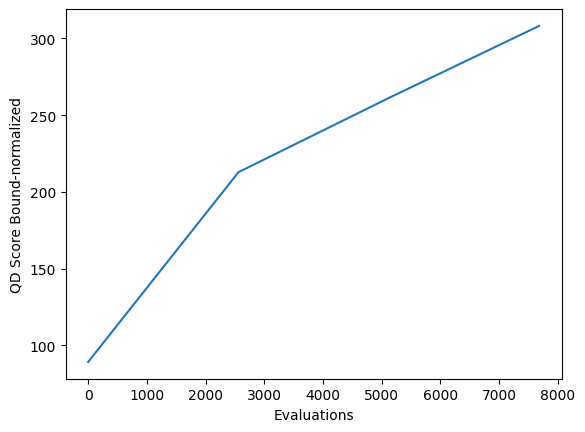

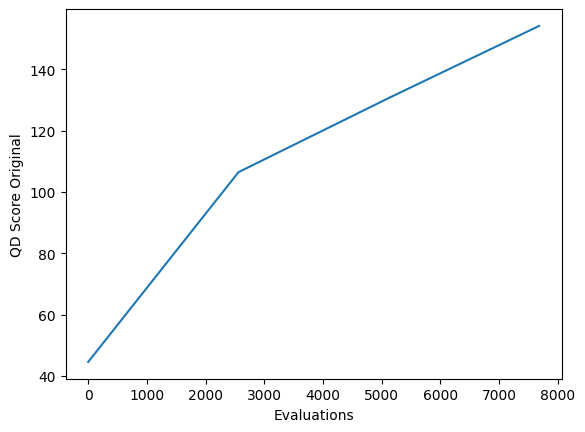

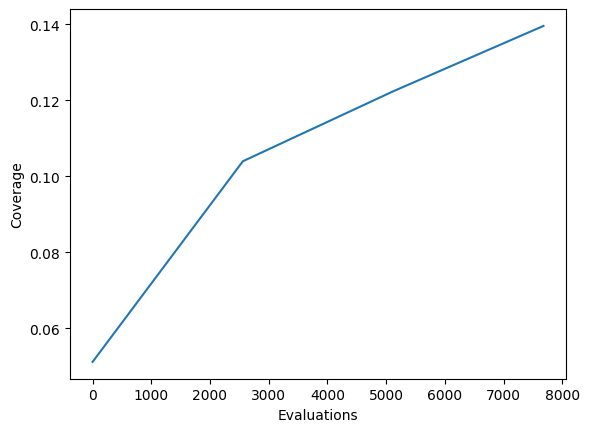

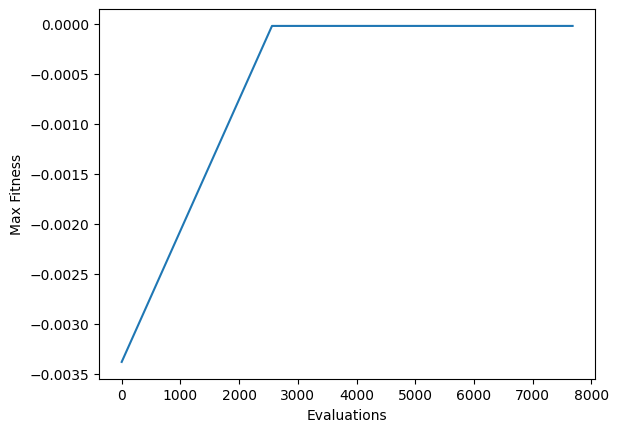

In [36]:
%matplotlib inline

for name_metric, values in metrics_dict.items():
    plt.figure()
    plt.plot(list_evaluations, values)
    plt.xlabel("Evaluations")
    plt.ylabel(name_metric)
    plt.show()

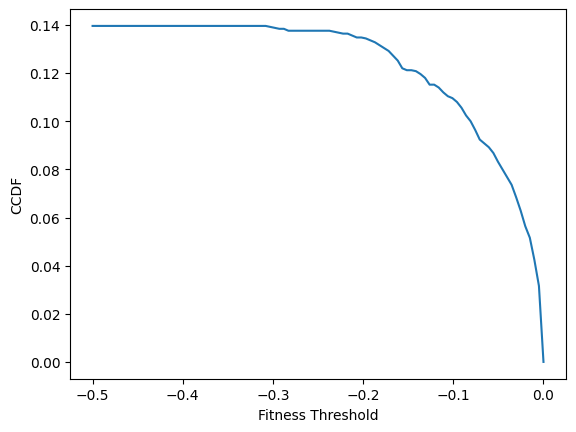

In [37]:
# Plotting Complementary Cumulative Density Fitness
ccdf = list_metrics[-1].ccdf
ccdf_fitness_bins = list_metrics[-1].ccdf_fitness_bins

plt.figure()
plt.plot(ccdf_fitness_bins, ccdf)
plt.xlabel("Fitness Threshold")
plt.ylabel("CCDF")
plt.show()

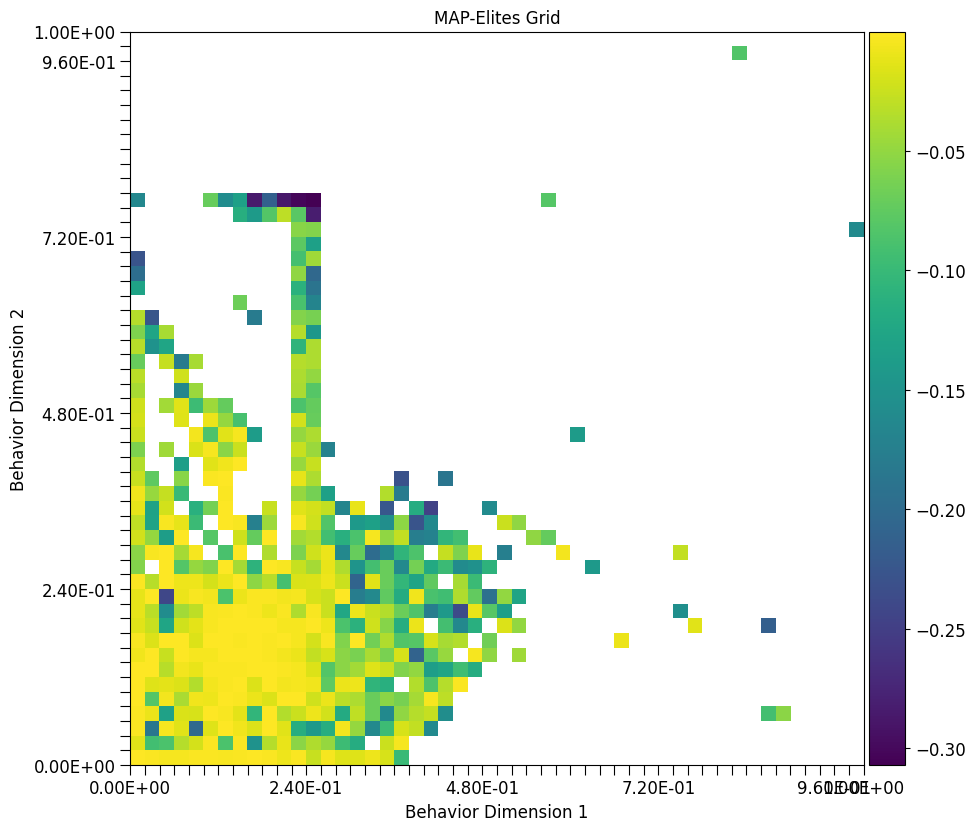

In [38]:
from qdax.utils.plotting import plot_multidimensional_map_elites_grid

plot_multidimensional_map_elites_grid(repertoire, 
                                      minval=jnp.asarray([0., 0.]), 
                                      maxval=jnp.asarray([1., 1.]), 
                                      grid_shape=grid_shape)
plt.show()